# Model Building

TODO:

-> try graph similarity network (add threshold to the correlations) -> https://gephi.org/

time series:
- recurrent ann
- pls model
- look at predicting score

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random

In [8]:
# Drop first column of dataframe
def drop_first_col(df):
    return df.iloc[: , 1:]

X_train = pd.read_csv("dataset\X_train_2_str.csv")
X_test = pd.read_csv("dataset\X_test_2_str.csv")
y_train = pd.read_csv("dataset\y_train_2_str.csv")
y_test = pd.read_csv("dataset\y_test_2_str.csv")

X_train = drop_first_col(X_train)
X_test = drop_first_col(X_test)
y_train = drop_first_col(y_train)
y_test = drop_first_col(y_test)

## Test on single simple models

### Single XGB Classifier (with no hyperparameters selection)

In [9]:
def XGB_class(X_train, X_test, y_train, y_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print(classification_report(y_test, y_predicted))

In [10]:
XGB_class(X_train,X_test,y_train,y_test,0,0,0,0,0,0,0,simple=True)

Accuracy: 0.6296296296296297
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.71      0.71      0.71        17

    accuracy                           0.63        27
   macro avg       0.60      0.60      0.60        27
weighted avg       0.63      0.63      0.63        27



### SVM

In [11]:
clf = SVC(kernel='linear') 
  
# fitting x samples and y classes 
clf.fit(X_train, y_train) 
y_predicted = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

Accuracy: 0.5925925925925926
              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.69      0.65      0.67        17

    accuracy                           0.59        27
   macro avg       0.57      0.57      0.57        27
weighted avg       0.60      0.59      0.60        27



C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Single Random Forest classifier

In [12]:
# evaluate random forest algorithm for classification
# define the model
model = RandomForestClassifier().fit(X_train,y_train)
y_predicted = model.predict(X_test)
# report performance
print("Accuracy:", accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

<ipython-input-12-22d5d04bd9f3>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier().fit(X_train,y_train)


Accuracy: 0.7037037037037037
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.74      0.82      0.78        17

    accuracy                           0.70        27
   macro avg       0.68      0.66      0.67        27
weighted avg       0.70      0.70      0.70        27



### Logistic Regression

In [13]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predicted = model.predict(X_test)
# report performance
print("Accuracy:", accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

Accuracy: 0.5925925925925926
              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.69      0.65      0.67        17

    accuracy                           0.59        27
   macro avg       0.57      0.57      0.57        27
weighted avg       0.60      0.59      0.60        27



C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Features Selection

### Recursive Feature Elimination (RFE)

In [14]:
def rfe_xgb(X_train, y_train,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    min_features_to_select = 50
    
    #run RFE on current train subset
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)
    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train)
    
    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])

    plt.figure()
    lines = []
    for i in range(rfecv.grid_scores_.shape[1]):
        lines.append(plt.plot(rfecv.grid_scores_[:,i]))

    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.legend(lines,labels = ['fold 1', 'fold 2', 'fold 3','fold 4', 'fold 5'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return newX_train,newX_test

### Test on single XGB classifier using RFE selected features

We kept 56 features out of the 320


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(m

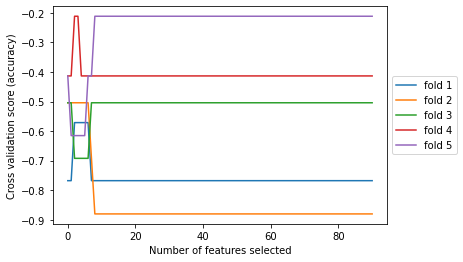

Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.82      0.82      0.82        17

    accuracy                           0.78        27
   macro avg       0.76      0.76      0.76        27
weighted avg       0.78      0.78      0.78        27



In [15]:
#test rfe then simple XGB classifier
newX_train,newX_test = rfe_xgb(X_train, y_train,0,0,0,0,0,0,0,simple=True)
XGB_class(newX_train,newX_test,y_train,y_test,0,0,0,0,0,0,0,simple=True)

## Hyperparameter tuning XGBoost classifier

### Using Evolutionary Computation

In [16]:
random.seed(723)
np.random.seed(723)

def initilialize_poplulation(numberOfParents):
    learningRate = np.empty([numberOfParents, 1])
    nEstimators = np.empty([numberOfParents, 1], dtype = np.uint8)
    maxDepth = np.empty([numberOfParents, 1], dtype = np.uint8)
    minChildWeight = np.empty([numberOfParents, 1])
    gammaValue = np.empty([numberOfParents, 1])
    subSample = np.empty([numberOfParents, 1])
    colSampleByTree =  np.empty([numberOfParents, 1])

    for i in range(numberOfParents):
        learningRate[i] = round(random.uniform(0.01, 1), 2)
        nEstimators[i] = random.randrange(10, 1500, step = 25)
        maxDepth[i] = int(random.randrange(1, 10, step= 1))
        minChildWeight[i] = round(random.uniform(0.01, 10.0), 2)
        gammaValue[i] = round(random.uniform(0.01, 10.0), 2)
        subSample[i] = round(random.uniform(0.01, 1.0), 2)
        colSampleByTree[i] = round(random.uniform(0.01, 1.0), 2)
    
    population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree), axis= 1)
    return population

   

def fitness_accuracy_score(y_true, y_pred):
    fitness = round((accuracy_score(y_true, y_pred)), 4)
    return fitness

def train_population(population, dMatrixTrain, dMatrixtest, y_test):
    aScore = []
    for i in range(population.shape[0]):
        param = { 'objective':'binary:logistic',
              'learning_rate': population[i][0],
              'n_estimators': population[i][1], 
              'max_depth': int(population[i][2]), 
              'min_child_weight': population[i][3],
              'gamma': population[i][4], 
              'subsample': population[i][5],
              'colsample_bytree': population[i][6],
              'seed': 24}
        num_round = 100
        xgbT = xgb.train(param, dMatrixTrain, num_round)
        preds = xgbT.predict(dMatrixtest)
        preds = preds>0.5
        aScore.append(fitness_accuracy_score(y_test, preds))
    return aScore



def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) 
    
    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 
    return selectedParents
        

def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8)
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) 
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) 
    
    children = np.empty(childrenSize)
    
    
    for i in range(childrenSize[0]):
        
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
    return children
    


def mutation(crossover, numberOfParameters):

    minMaxValue = np.zeros((numberOfParameters, 2))
    
    minMaxValue[0:] = [0.01, 1.0] 
    minMaxValue[1, :] = [10, 2000] 
    minMaxValue[2, :] = [1, 15] 
    minMaxValue[3, :] = [0, 10.0] 
    minMaxValue[4, :] = [0.01, 10.0] 
    minMaxValue[5, :] = [0.01, 1.0] 
    minMaxValue[6, :] = [0.01, 1.0] 
 
    
    mutationValue = 0
    parameterSelect = np.random.randint(0, 7, 1)
    print(parameterSelect)
    if parameterSelect == 0: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 1: 
        mutationValue = np.random.randint(-200, 200, 1)
    if parameterSelect == 2:
        mutationValue = np.random.randint(-5, 5, 1)
    if parameterSelect == 3: 
        mutationValue = round(np.random.uniform(5, 5), 2)
    if parameterSelect == 4: 
        mutationValue = round(np.random.uniform(-2, 2), 2)
    if parameterSelect == 5: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 6: 
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
  
    
    for idx in range(crossover.shape[0]):
        crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
        if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
        if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]    
    return crossover

In [17]:
def hyp_param_ev_algo(X_train, X_test, y_train, y_test):
    xgDMatrix = xgb.DMatrix(X_train, y_train) 
    xgbDMatrixTest = xgb.DMatrix(X_test, y_test)

    numberOfParents = 100 
    numberOfParentsMating = int(numberOfParents/2)
    numberOfParameters = 7 
    numberOfGenerations = 50

    populationSize = (numberOfParents, numberOfParameters)
    population = initilialize_poplulation(numberOfParents)

    fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])
    populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])
    populationHistory[0:numberOfParents, :] = population

    for generation in range(numberOfGenerations):
        print("This is number %s generation" % (generation))

        fitnessValue = train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=y_test)
        fitnessHistory[generation, :] = fitnessValue

        print('Best Accuracy score in the this iteration = {}'.format(np.max(fitnessHistory[generation, :])))

        parents = new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
        children = crossover_uniform(parents=parents, childrenSize=(populationSize[0] - parents.shape[0], numberOfParameters))
        children_mutated = mutation(children, numberOfParameters)

        population[0:parents.shape[0], :] = parents 
        population[parents.shape[0]:, :] = children_mutated 

        populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population 

    fitness = train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=y_test)
    fitnessHistory[generation+1, :] = fitness

    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]

    print("Best fitness is =", fitness[bestFitnessIndex])


    print("Best parameters are:")
    print('learning_rate', population[bestFitnessIndex][0])
    print('n_estimators', population[bestFitnessIndex][1])
    print('max_depth', int(population[bestFitnessIndex][2])) 
    print('min_child_weight', population[bestFitnessIndex][3])
    print('gamma', population[bestFitnessIndex][4])
    print('subsample', population[bestFitnessIndex][5])
    print('colsample_bytree', population[bestFitnessIndex][6])
    
    return population[bestFitnessIndex][0],population[bestFitnessIndex][1],population[bestFitnessIndex][2],population[bestFitnessIndex][3],population[bestFitnessIndex][4],population[bestFitnessIndex][5],population[bestFitnessIndex][6]

### Forward (first RFE, then tuning hyperparameters on selected features)

We kept 56 features out of the 320


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(m

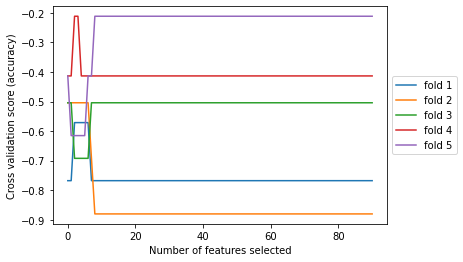

This is number 0 generation
Best Accuracy score in the this iteration = 0.7778
[2]
This is number 1 generation
Best Accuracy score in the this iteration = 0.7778
[2]
This is number 2 generation
Best Accuracy score in the this iteration = 0.7778
[1]
This is number 3 generation
Best Accuracy score in the this iteration = 0.7778
[2]
This is number 4 generation
Best Accuracy score in the this iteration = 0.7778
[4]
This is number 5 generation
Best Accuracy score in the this iteration = 0.8519
[1]
This is number 6 generation
Best Accuracy score in the this iteration = 0.8519
[2]
This is number 7 generation
Best Accuracy score in the this iteration = 0.8519
[4]
This is number 8 generation
Best Accuracy score in the this iteration = 0.8519
[1]
This is number 9 generation
Best Accuracy score in the this iteration = 0.8519
[3]
This is number 10 generation
Best Accuracy score in the this iteration = 0.8519
[0]
This is number 11 generation
Best Accuracy score in the this iteration = 0.8519
[0]
Th

In [18]:
#test tuning XGB hyperparameters with selected features from RFE
newX_train,newX_test = rfe_xgb(X_train, y_train,0,0,0,0,0,0,0,simple=True)
learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree = hyp_param_ev_algo(newX_train, newX_test, y_train, y_test)
XGB_class(newX_train,newX_test,y_train,y_test,learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree,simple=False)

### Backward (first tuning hyperparameters on selected features, then RFE)

This is number 0 generation
Best Accuracy score in the this iteration = 0.7407
[0]
This is number 1 generation
Best Accuracy score in the this iteration = 0.7407
[3]
This is number 2 generation
Best Accuracy score in the this iteration = 0.7407
[2]
This is number 3 generation
Best Accuracy score in the this iteration = 0.8148
[3]
This is number 4 generation
Best Accuracy score in the this iteration = 0.8148
[5]
This is number 5 generation
Best Accuracy score in the this iteration = 0.8148
[0]
This is number 6 generation
Best Accuracy score in the this iteration = 0.8148
[0]
This is number 7 generation
Best Accuracy score in the this iteration = 0.8148
[6]
This is number 8 generation
Best Accuracy score in the this iteration = 0.8148
[1]
This is number 9 generation
Best Accuracy score in the this iteration = 0.8148
[0]
This is number 10 generation
Best Accuracy score in the this iteration = 0.8148
[4]
This is number 11 generation
Best Accuracy score in the this iteration = 0.8148
[6]
Th

C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(m

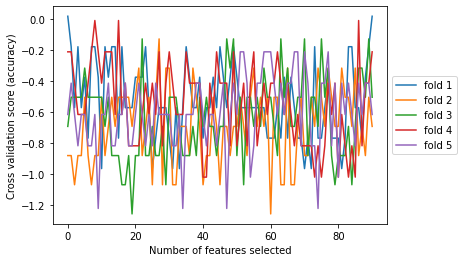

Accuracy: 0.7037037037037037
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.74      0.82      0.78        17

    accuracy                           0.70        27
   macro avg       0.68      0.66      0.67        27
weighted avg       0.70      0.70      0.70        27



In [19]:
#test RFE with tuning XGB hyperparameters
learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree = hyp_param_ev_algo(X_train, X_test, y_train, y_test)
newX_train,newX_test = rfe_xgb(X_train, y_train,learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree,simple=False)
XGB_class(newX_train,newX_test,y_train,y_test,learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree,simple=False)